In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =5e-25

nband = 80

ng =5

ng_refs = (/ 5 /) 

nref =1

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 600 /) 

t_refs = (/ 250 /) 

tsfc =294

vstar = 720

data w_diffuse
     &     /1.8 , 1.8 , 1.8 , 1.8,
     &     1.8/

data wgt
     &     /0.5 , 0.5 , 0.6 , 0.7,
     &     0.9/

atmosphere_profiles/mls75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

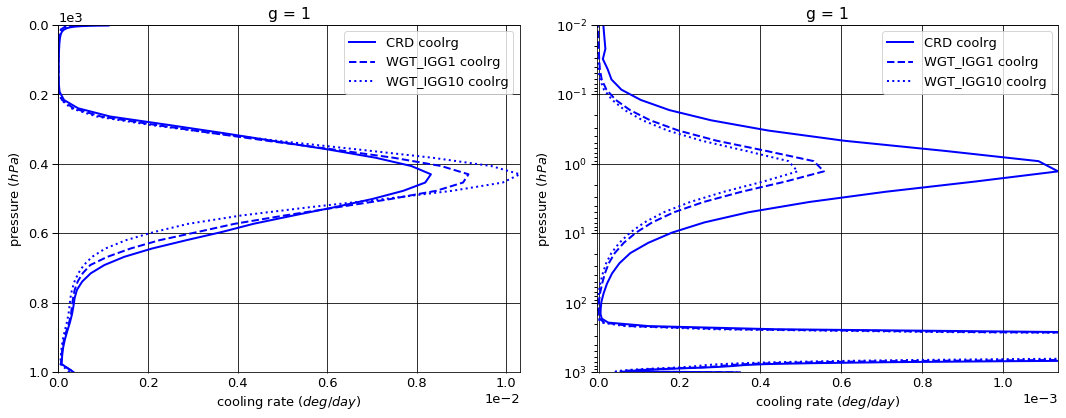

# Figure: cooling rate g-group 2

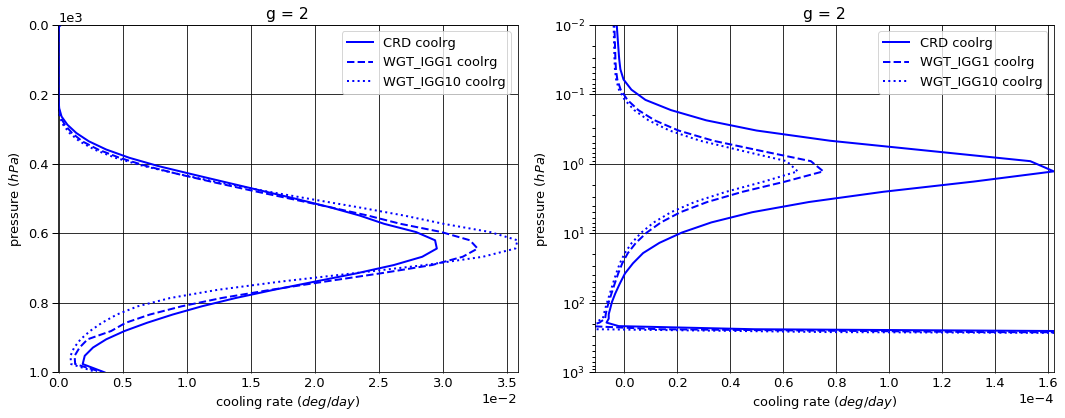

# Figure: cooling rate g-group 3

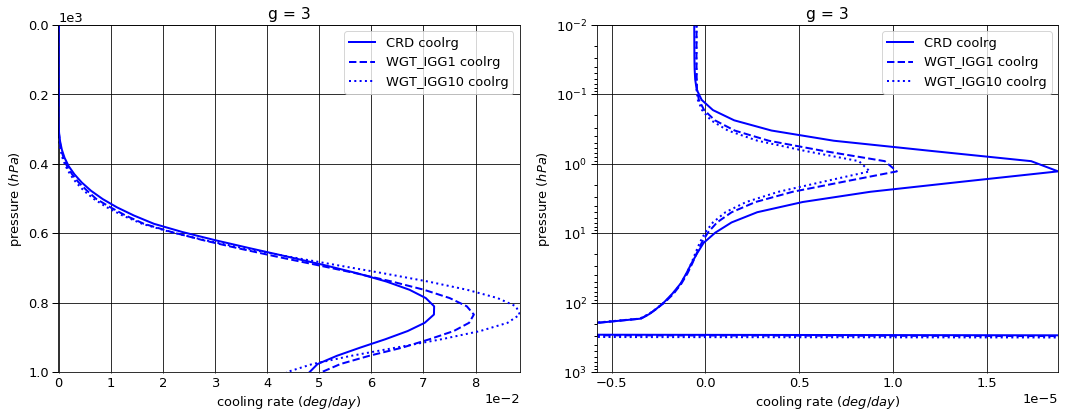

# Figure: cooling rate g-group 4

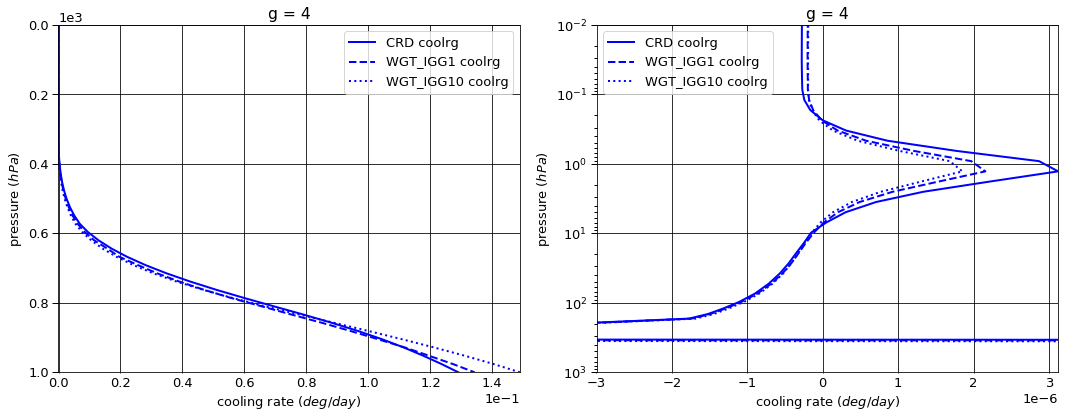

# Figure: cooling rate g-group 5

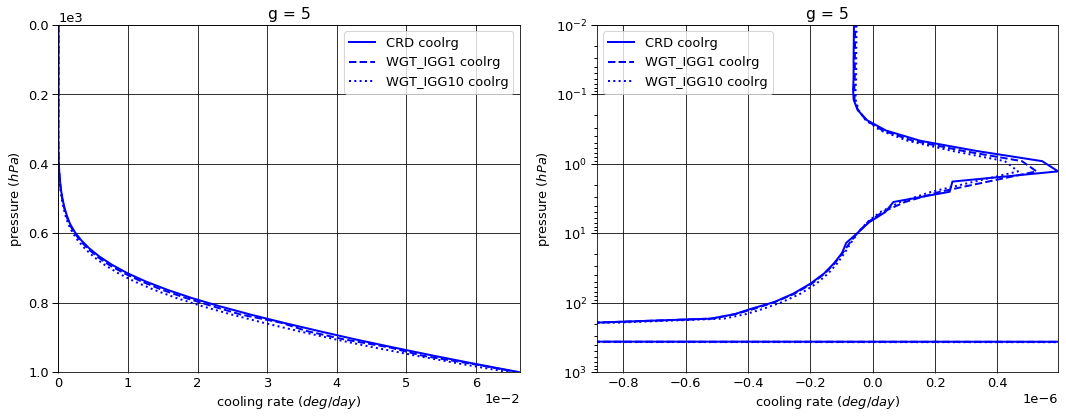

# Figure: cooling rate g-group total

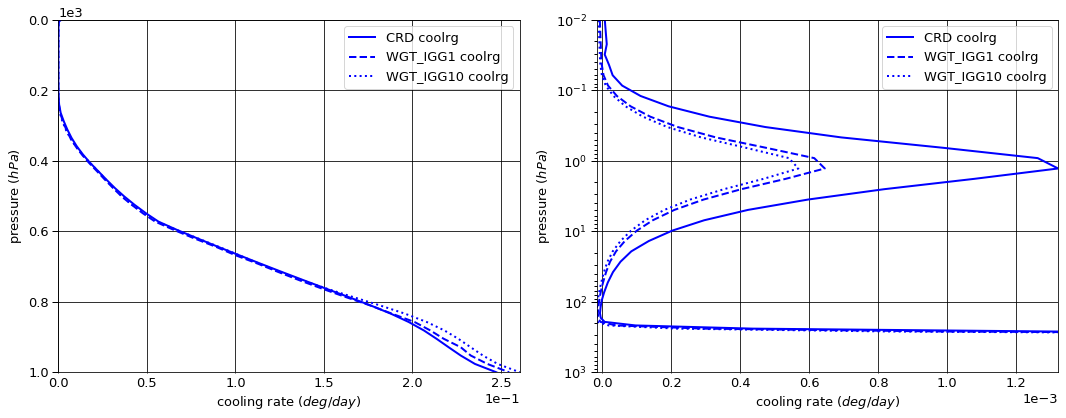

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.271164  0.000000  -0.271164
  1013.0   76     -0.504281  0.503392  -0.000889
2 0.0      1      -1.171545  0.000000  -1.171545
  1013.0   76     -1.690541  1.677799  -0.012742
3 0.0      1      -3.586963  0.000000  -3.586963
  1013.0   76     -4.186144  3.603471  -0.582673
4 0.0      1      -9.034885  0.000000  -9.034885
  1013.0   76     -9.448573  3.849371  -5.599201
5 0.0      1     -16.675551  0.000000 -16.675551
  1013.0   76    -16.808004  1.478629 -15.329375


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.269687  0.000000  -0.269687
  1013.0   76     -0.504281  0.503352  -0.000929
2 0.0      1      -1.171280  0.000000  -1.171280
  1013.0   76     -1.690541  1.679629  -0.010912
3 0.0      1      -3.590275  0.000000  -3.590275
  1013.0   76     -4.186144  3.741801  -0.444343
4 0.0      1      -9.058940  0.000000  -9.058940
  1013.0   76     -9.448573  3.742069  -5.706503
5 0.0      1     -16.680753  0.000000 -16.680753
  1013.0   76    -16.808004  1.436305 -15.371700


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.265559  0.000000  -0.265559
  1013.0   76     -0.504281  0.503618  -0.000663
2 0.0      1      -1.157229  0.000000  -1.157229
  1013.0   76     -1.690541  1.681850  -0.008691
3 0.0      1      -3.565109  0.000000  -3.565109
  1013.0   76     -4.186144  3.904335  -0.281810
4 0.0      1      -9.061340  0.000000  -9.061340
  1013.0   76     -9.448573  3.907095  -5.541478
5 0.0      1     -16.689457  0.000000 -16.689457
  1013.0   76    -16.808004  1.368473 -15.439531


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.001477  0.000000  0.001477
  1013.0   76     0.000000 -0.000040 -0.000040
2 0.0      1      0.000265  0.000000  0.000265
  1013.0   76     0.000000  0.001830  0.001830
3 0.0      1     -0.003312  0.000000 -0.003312
  1013.0   76     0.000000  0.138331  0.138331
4 0.0      1     -0.024056  0.000000 -0.024056
  1013.0   76     0.000000 -0.107302 -0.107302
5 0.0      1     -0.005202  0.000000 -0.005202
  1013.0   76     0.000000 -0.042325 -0.042325


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.005605  0.000000  0.005605
  1013.0   76     0.000000  0.000226  0.000226
2 0.0      1      0.014316  0.000000  0.014316
  1013.0   76     0.000000  0.004051  0.004051
3 0.0      1      0.021854  0.000000  0.021854
  1013.0   76     0.000000  0.300864  0.300864
4 0.0      1     -0.026456  0.000000 -0.026456
  1013.0   76     0.000000  0.057723  0.057723
5 0.0      1     -0.013906  0.000000 -0.013906
  1013.0   76     0.000000 -0.110157 -0.110156

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.480801e-06
  1001.112500 75     3.411265e-04
2 0.000312    1     -4.632943e-06
  1001.112500 75     3.584563e-03
3 0.000312    1     -5.924702e-07
  1001.112500 75     4.811100e-02
4 0.000312    1     -2.658845e-07
  1001.112500 75     1.290216e-01
5 0.000312    1     -5.658241e-08
  1001.112500 75     6.633627e-02


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -8.543276e-06
  1001.112500 75     3.521343e-04
2 0.000312    1     -4.454721e-06
  1001.112500 75     3.433306e-03
3 0.000312    1     -4.498674e-07
  1001.112500 75     5.038662e-02
4 0.000312    1     -1.909776e-07
  1001.112500 75     1.342720e-01
5 0.000312    1     -5.254767e-08
  1001.112500 75     6.616916e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -1.072223e-05
  1001.112500 75     2.536612e-04
2 0.000312    1     -4.623198e-06
  1001.112500 75     2.988897e-03
3 0.000312    1     -4.453223e-07
  1001.112500 75     4.367871e-02
4 0.000312    1     -1.831723e-07
  1001.112500 75     1.488600e-01
5 0.000312    1     -4.851293e-08
  1001.112500 75     6.484305e-02


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -6.062475e-06
  1001.112500 75     1.100776e-05
2 0.000312    1      1.782220e-07
  1001.112500 75    -1.512574e-04
3 0.000312    1      1.426028e-07
  1001.112500 75     2.275621e-03
4 0.000312    1      7.490685e-08
  1001.112500 75     5.250360e-03
5 0.000312    1      4.034739e-09
  1001.112500 75    -1.671040e-04


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -8.241425e-06
  1001.112500 75    -8.746531e-05
2 0.000312    1      9.744700e-09
  1001.112500 75    -5.956658e-04
3 0.000312    1      1.471479e-07
  1001.112500 75    -4.432296e-03
4 0.000312    1      8.271214e-08
  1001.112500 75     1.983837e-02
5 0.000312    1      8.069478e-09
  1001.112500 75    -1.493214e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.740107,0.000000,-30.740107
1013.0,76,-32.637543,11.112662,-21.524881



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.770935,0.000000,-30.770935
1013.0,76,-32.637543,11.103156,-21.534387



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.738694,0.00000,-30.738694
1013.0,76,-32.637543,11.36537,-21.272172



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.030828,0.000000,-0.030828
1013.0,76,0.000000,-0.009506,-0.009507



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.001413,0.000000,0.001413
1013.0,76,0.000000,0.252708,0.252708


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000008
1001.112500,75,0.247395



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000014
1001.112500,75,0.254613



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000016
1001.112500,75,0.260624



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000006
1001.112500,75,0.007219



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000008
1001.112500,75,0.013230


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.015500,0.015423
2,0.052000,0.051652
3,0.128688,0.127952
4,0.290063,0.289068
5,0.513750,0.515905


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.501949e-22
2,2.243039e-23
3,3.349798e-24
4,5.002654e-25
5,3.765264e-26


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.501949e-22,NaN,0.015500,0.015423,0.015500,0.015423,600.0
2,2.243039e-23,0.149342,0.052000,0.051652,0.067500,0.067075,600.0
3,3.349798e-24,0.149342,0.128688,0.127952,0.196188,0.195027,600.0
4,5.002654e-25,0.149342,0.290063,0.289068,0.486250,0.484095,600.0
5,3.765264e-26,0.075265,0.513750,0.515905,1.000000,1.000000,600.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     2.345147e-22  7.706397e-24  30.431172  1.031391e-08
      2 0.000312     1.057558e-23  2.622546e-25  40.325601  4.614810e-10
      3 0.000312     1.992103e-25  1.407673e-26  14.151746  1.065850e-11
      4 0.000312     2.468853e-26  2.752583e-27   8.969220  1.542076e-12
      5 0.000312     2.808884e-27  1.678861e-28  16.730886  2.167167e-13
2     1 0.000750     2.359667e-22  7.722987e-24  30.553810  4.179494e-09
      2 0.000750     1.062494e-23  2.631795e-25  40.371467  1.867410e-10
      3 0.000750     2.013589e-25  1.411238e-26  14.268244  4.337813e-12
      4 0.000750     2.488456e-26  2.764746e-27   9.000670  6.259599e-13
      5 0.000750     2.832969e-27  1.686397e-28  16.798948  8.803675e-14
3     1 0.001052     2.390792e-22  7.755460e-24  30.827210  5.936906e-09
      2 0.001052     1.073103e-23  2.650279e-25  40.490164  2.644788e-10
      3 0.001052     2.059966e-25  1.418120e-26  14.526033  6.218466e-12
      4 0.001052     2.530567e-26  2.789819e-27   9.070720  8.923791e-13
      5 0.001052     2.884800e-27  1.701281e-28  16.956637  1.257126e-13
4     1 0.001476     2.424136e-22  7.790178e-24  31.117850  8.442521e-09
      2 0.001476     1.084503e-23  2.670282e-25  40.613801  3.749495e-10
      3 0.001476     2.110240e-25  1.425299e-26  14.805600  8.929341e-12
      4 0.001476     2.576001e-26  2.816763e-27   9.145252  1.273920e-12
      5 0.001476     2.940875e-27  1.717376e-28  17.124231  1.797779e-13
5     1 0.002070     2.457917e-22  7.825570e-24  31.408791  1.200292e-08
      2 0.002070     1.096091e-23  2.690885e-25  40.733483  5.314811e-10
      3 0.002070     2.161803e-25  1.432434e-26  15.091820  1.281972e-11
      4 0.002070     2.622383e-26  2.844252e-27   9.219939  1.818295e-12
      5 0.002070     2.998280e-27  1.733983e-28  17.291293  2.570600e-13
6     1 0.002904     2.492104e-22  7.861942e-24  31.698322  1.706632e-08
      2 0.002904     1.107859e-23  2.712253e-25  40.846435  7.534827e-10
      3 0.002904     2.214638e-25  1.439589e-26  15.383823  1.840741e-11
      4 0.002904     2.669700e-26  2.872390e-27   9.294351  2.595690e-12
      5 0.002904     3.057002e-27  1.751251e-28  17.456107  3.676279e-13
7     1 0.004074     2.526695e-22  7.899791e-24  31.984327  2.426584e-08
      2 0.004074     1.119808e-23  2.734642e-25  40.948963  1.068301e-09
      3 0.004074     2.268776e-25  1.446867e-26  15.680610  2.643184e-11
      4 0.004074     2.717986e-26  2.901359e-27   9.367978  3.705738e-12
      5 0.004074     3.117086e-27  1.769414e-28  17.616485  5.258042e-13
8     1 0.005714     2.561687e-22  7.939821e-24  32.263786  3.449953e-08
      2 0.005714     1.131938e-23  2.758413e-25  41.035861  1.514642e-09
      3 0.005714     2.324247e-25  1.454415e-26  15.980630  3.795282e-11
      4 0.005714     2.767279e-26  2.931411e-27   9.440094  5.290465e-12
      5 0.005714     3.178583e-27  1.788800e-28  17.769357  7.520452e-13
9     1 0.008015     2.597078e-22  7.983038e-24  32.532454  4.904939e-08
      2 0.008015     1.144254e-23  2.784081e-25  41.099881  2.147647e-09
      3 0.008015     2.381091e-25  1.462443e-26  16.281602  5.449863e-11
      4 0.008015     2.817632e-26  2.962908e-27   9.509684  7.553644e-12
      5 0.008015     3.241563e-27  1.809872e-28  17.910451  1.075754e-12
10    1 0.011243     2.632850e-22  8.030850e-24  32.784197  6.973300e-08
      2 0.011243     1.156751e-23  2.812368e-25  41.130860  3.045340e-09
      3 0.011243     2.439330e-25  1.471248e-26  16.580007  7.825923e-11
      4 0.011243     2.869091e-26  2.996353e-27   9.575280  1.078578e-11
      5 0.011243     3.306087e-27  1.833279e-28  18.033737  1.538926e-12
11    1 0.015771     2.668976e-22  8.085250e-24  33.010431  9.913770e-08
      2 0.015771     1.169426e-23  2.844298e-25  41.114754  4.318596e-09
      3 0.015771     2.498979e-25  1.481250e-26  16.870742  1.123850e-10
      4 0.0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
